In [1]:
import torch
from torch import nn

import torchvision
import sklearn
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

In [3]:
#make 10000 samples
n_samples = 10000

In [4]:
#make circles,keep random state so get same values
X,y=make_circles(n_samples,noise=0.03,random_state=42)

In [5]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")


First 5 X features:
[[ 0.0464692   0.82477834]
 [ 1.00506323 -0.43335153]
 [-0.58348442  0.79452834]
 [ 0.98478298 -0.32517879]
 [ 0.82993028 -0.54722305]]

First 5 y labels:
[1 0 0 0 0]


In [6]:
#Make DF of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)


,X1,X2,label
0,0.046469,0.824778,1
1,1.005063,-0.433352,0
2,-0.583484,0.794528,0
3,0.984783,-0.325179,0
4,0.829930,-0.547223,0
5,-0.133929,0.776249,1
6,0.779197,0.645811,0
7,0.722955,0.173831,1
8,-0.121807,0.796951,1
9,0.849529,0.505678,0


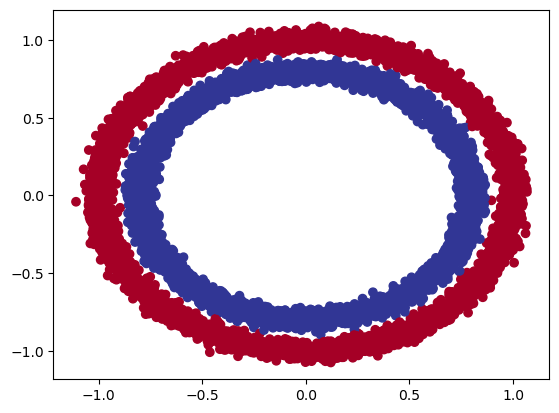

In [7]:
# Visualize with color map red yellow blue
plt.scatter(x=X[:,0],
           y=X[:,1],
            c=y,
cmap=plt.cm.RdYlBu);

In [8]:
X.shape,y.shape

((10000, 2), (10000,))

In [9]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.0464692  0.82477834] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [10]:
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

X[:5],y[:5]

(tensor([[ 0.0465,  0.8248],
         [ 1.0051, -0.4334],
         [-0.5835,  0.7945],
         [ 0.9848, -0.3252],
         [ 0.8299, -0.5472]]),
 tensor([1., 0., 0., 0., 0.]))

In [11]:
#80% training,20% testing
#800 training samples and 200 testing samples
X_train,X_test,y_train,y_test=train_test_split(X,
                                              y,
                                              test_size=0.2,
                                              random_state=42)
len(X_train),len(X_test),len(y_train),len(y_test)

(8000, 2000, 8000, 2000)

## Building Model

In [12]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [13]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        #create 2 neural network capable of handling X and y input and output
        self.layer_1=nn.Linear(in_features=2,out_features=5)#takes in 2 features (X),produces 5 features
        self.layer_2=nn.Linear(in_features=5,out_features=1)#takes in 5 features, produces 1 feature(y)
    
    #Define 1 forward method containing the forward pass computation
    def forward(self,x):
        #Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x))

model_0=CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

Having 5 neurons => layer turns input data from having 2 features to 5

In [14]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 2000, Shape: torch.Size([2000, 1])
Length of test samples: 2000, Shape: torch.Size([2000])

First 10 predictions:
tensor([[0.1465],
        [0.3543],
        [0.6675],
        [0.5595],
        [0.0969],
        [0.6044],
        [0.6054],
        [0.6133],
        [0.5978],
        [0.3604]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 1., 0., 1., 0., 1., 1., 1., 1., 1.])


In [15]:
# Create a loss function (how wrong model prediction are)
loss_fn = nn.BCEWithLogitsLoss()

#optimizer
optimizer=torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [16]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.3946,  0.5239],
                      [ 0.5420, -0.0616],
                      [ 0.6471, -0.0497],
                      [-0.0924,  0.6578],
                      [ 0.5702, -0.5503]])),
             ('layer_1.bias',
              tensor([ 0.0760, -0.3082, -0.2946, -0.5925, -0.1146])),
             ('layer_2.weight',
              tensor([[ 0.2647,  0.3020,  0.2498, -0.3564,  0.0124]])),
             ('layer_2.bias', tensor([0.3147]))])

In [17]:
#calculate accurasy
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [18]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.1465],
        [0.3543],
        [0.6675],
        [0.5595],
        [0.0969]], grad_fn=<SliceBackward0>)

## Train Model

In [19]:
#sigmoid on model logtis
y_pred_probs=torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5366],
        [0.5877],
        [0.6609],
        [0.6363],
        [0.5242]], grad_fn=<SigmoidBackward0>)

In [20]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)

In [21]:
y_test[:5]

tensor([1., 1., 0., 1., 0.])

In [22]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71499, Accuracy: 50.16% | Test loss: 0.71423, Test acc: 49.35%
Epoch: 10 | Loss: 0.70382, Accuracy: 54.84% | Test loss: 0.70343, Test acc: 55.80%
Epoch: 20 | Loss: 0.69898, Accuracy: 54.79% | Test loss: 0.69871, Test acc: 54.70%
Epoch: 30 | Loss: 0.69671, Accuracy: 52.65% | Test loss: 0.69650, Test acc: 52.65%
Epoch: 40 | Loss: 0.69553, Accuracy: 52.04% | Test loss: 0.69539, Test acc: 52.20%
Epoch: 50 | Loss: 0.69486, Accuracy: 51.36% | Test loss: 0.69479, Test acc: 52.10%
Epoch: 60 | Loss: 0.69444, Accuracy: 51.11% | Test loss: 0.69444, Test acc: 51.80%
Epoch: 70 | Loss: 0.69416, Accuracy: 51.16% | Test loss: 0.69423, Test acc: 51.25%
Epoch: 80 | Loss: 0.69397, Accuracy: 50.91% | Test loss: 0.69409, Test acc: 51.15%
Epoch: 90 | Loss: 0.69382, Accuracy: 51.15% | Test loss: 0.69399, Test acc: 51.00%


In [23]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

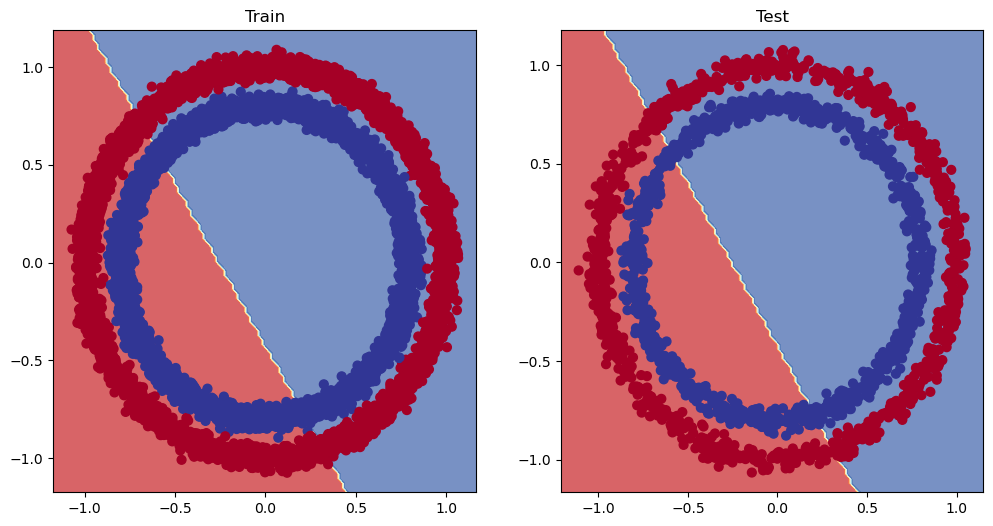

In [24]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

Model is undefitting

In [25]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): 
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [26]:
#loss function
loss_fn=nn.BCEWithLogitsLoss()
optimizer =torch.optim.SGD(model_1.parameters(),lr=0.1)

In [32]:
torch.manual_seed(42)

epochs=1000

X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

for epoch in range(epochs):
    #Training
    y_logits=model_1(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits)) #logits->prediction probability
    
    #calculate loss/accuracy
    loss=loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_true=y_train,
                y_pred=y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_1.eval()
    with torch.inference_mode():
        #forward pass
        test_logits=model_1(X_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logits))
        
        test_loss=loss_fn(test_logits,
                         y_test)
        test_acc=accuracy_fn(y_true=y_test,
                            y_pred=test_pred)
        
        if epoch%100==0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69361, Accuracy: 50.88% | Test loss: 0.69408, Test acc: 50.50%
Epoch: 100 | Loss: 0.69315, Accuracy: 51.06% | Test loss: 0.69336, Test acc: 50.50%
Epoch: 200 | Loss: 0.69313, Accuracy: 51.73% | Test loss: 0.69331, Test acc: 50.60%
Epoch: 300 | Loss: 0.69313, Accuracy: 52.09% | Test loss: 0.69331, Test acc: 50.85%
Epoch: 400 | Loss: 0.69313, Accuracy: 52.08% | Test loss: 0.69331, Test acc: 51.05%
Epoch: 500 | Loss: 0.69313, Accuracy: 52.10% | Test loss: 0.69332, Test acc: 51.30%
Epoch: 600 | Loss: 0.69313, Accuracy: 52.02% | Test loss: 0.69332, Test acc: 51.20%
Epoch: 700 | Loss: 0.69313, Accuracy: 52.02% | Test loss: 0.69332, Test acc: 51.20%
Epoch: 800 | Loss: 0.69313, Accuracy: 52.01% | Test loss: 0.69332, Test acc: 51.20%
Epoch: 900 | Loss: 0.69313, Accuracy: 52.00% | Test loss: 0.69332, Test acc: 51.20%


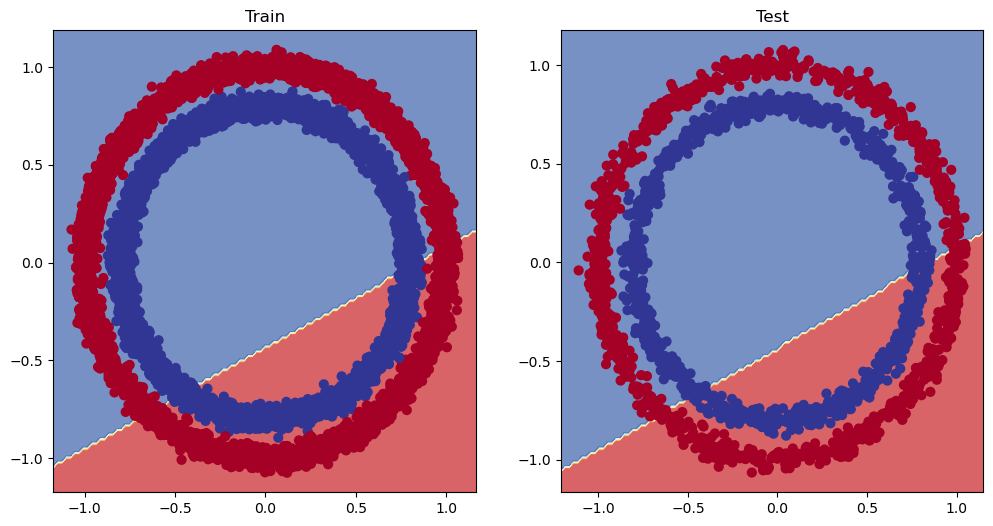

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)


## model not improving 

In [35]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)


CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [36]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)


In [37]:
torch.manual_seed(42)
epochs=1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    y_logits=model_3(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))
    
    loss=loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_true=y_train,
                   y_pred=y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_3.eval()
    with torch.inference_mode():
        test_logits=model_3(X_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logits))
        
        test_loss=loss_fn(test_logits,y_test)
        test_acc=accuracy_fn(y_true=y_test,
                            y_pred=test_pred)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69297, Accuracy: 50.16% | Test Loss: 0.69293, Test Accuracy: 49.35%
Epoch: 100 | Loss: 0.69108, Accuracy: 57.65% | Test Loss: 0.69089, Test Accuracy: 59.20%
Epoch: 200 | Loss: 0.68953, Accuracy: 54.59% | Test Loss: 0.68924, Test Accuracy: 54.95%
Epoch: 300 | Loss: 0.68741, Accuracy: 54.39% | Test Loss: 0.68703, Test Accuracy: 54.90%
Epoch: 400 | Loss: 0.68407, Accuracy: 54.15% | Test Loss: 0.68356, Test Accuracy: 54.80%
Epoch: 500 | Loss: 0.67920, Accuracy: 53.99% | Test Loss: 0.67871, Test Accuracy: 55.25%
Epoch: 600 | Loss: 0.67162, Accuracy: 55.10% | Test Loss: 0.67118, Test Accuracy: 56.90%
Epoch: 700 | Loss: 0.66120, Accuracy: 60.52% | Test Loss: 0.66071, Test Accuracy: 60.80%
Epoch: 800 | Loss: 0.64517, Accuracy: 67.86% | Test Loss: 0.64425, Test Accuracy: 68.00%
Epoch: 900 | Loss: 0.61346, Accuracy: 75.50% | Test Loss: 0.61209, Test Accuracy: 75.40%


In [38]:
#evaluating model
model_3.eval()
with torch.inference_mode():
    y_preds=torch.round(torch.sigmoid(model_3(X_test))).squeeze()
    
y_preds[:10],y[:10]

(tensor([0., 1., 0., 1., 0., 1., 1., 1., 1., 1.]),
 tensor([1., 0., 0., 0., 0., 1., 0., 1., 1., 0.]))

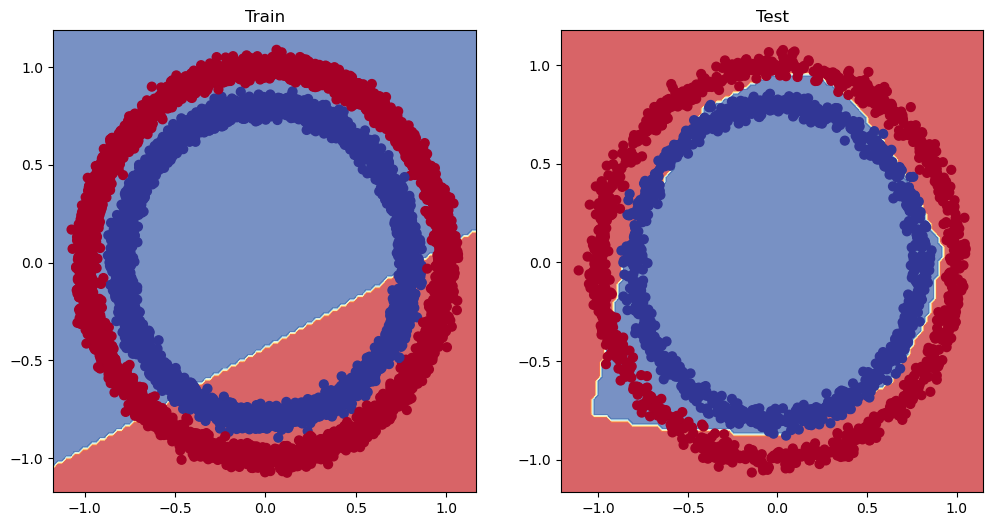

In [39]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity
